In [ ]:
!uv pip install -q --system numba-cuda==0.4.0

In [1]:
import os; os.environ["NUMBA_ENABLE_CUDASIM"] = "1"; os.environ["NUMBA_CUDA_DEBUGINFO"] = "1";
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0
import numpy as np
import numba as nb
from numba import cuda
from numba import njit
import random
cuda.select_device(0)

# Последовательный вариант

In [2]:
text = 'aabaabaaaabaabaaabaa'
pattern = 'aabaa'
n = len(text)
m = len(pattern)

In [3]:
def get_failure_links(pattern):
    result = np.zeros(len(pattern), dtype='i')
    k = 0
    for i in range(1, len(pattern)):
        while k > 0 and pattern[i] != pattern[k]:
            k = result[k - 1]
        if pattern[i] == pattern[k]:
            k += 1
        result[i] = k
    return result

In [4]:
def kmp(text, pattern, fail):
    fail = get_failure_links(pattern)
    results = np.zeros(len(text))
    k = 0
    for i in range(len(text)):
      while k > 0 and text[i] != pattern[k]:   
          k = fail[k - 1]
      if text[i] == pattern[k]:
          results[i]=k
          k += 1
      if k == len(pattern):
          results[i]=k
          k = fail[k - 1]  
    return np.array(results)

In [5]:
fail = get_failure_links(pattern)
result = kmp(text, pattern, fail)
print(result)

[0. 1. 2. 3. 5. 2. 3. 5. 1. 1. 2. 3. 5. 2. 3. 5. 1. 2. 3. 5.]


# Парралельный вариант

In [6]:
@njit
def get_failure_links_njit(pattern):
    result = np.zeros(len(pattern), dtype='i')
    k = 0
    for i in range(1, len(pattern)):
        while k > 0 and pattern[i] != pattern[k]:
            k = result[k - 1]
        if pattern[i] == pattern[k]:
            k += 1
        result[i] = k
    return result

In [7]:
@cuda.jit
def kmp_cuda(text, pattern, fail, results, segment_starts, segment_end):
    tdx = cuda.grid(1)
    k = 0
    for i in range(segment_starts[tdx], segment_end[tdx]):
      while k > 0 and text[i] != pattern[k]:
          k = fail[k - 1]
          cuda.atomic.max(results, i, k)
      if text[i] == pattern[k]:
          k += 1
          cuda.atomic.max(results, i, k)
      if k == len(pattern):
          cuda.atomic.max(results, i, k)
          k = fail[k - 1]  

In [8]:
fail = get_failure_links_njit(pattern)
p =  2

d_text = cuda.to_device(np.array(list(text)))
d_pattern = cuda.to_device(np.array(list(pattern)))
d_fail = cuda.to_device(np.array(fail, dtype=np.int32))
d_results = cuda.to_device(np.zeros(n, dtype=np.int32))

segment_starts1 = np.arange(0, n, n//p, dtype=np.int32)
segment_starts2 = np.arange(n//p//2, n-n//p, n//p, dtype=np.int32)
segment_starts = np.sort(np.concatenate([segment_starts1, segment_starts2]))
segment_ends = segment_starts + n//p
d_segment_starts = cuda.to_device(segment_starts)
d_segment_ends = cuda.to_device(segment_ends)

threadsperblock = segment_starts.size
blockspergrid = 1

kmp_cuda[blockspergrid, threadsperblock](d_text, d_pattern, d_fail, d_results, d_segment_starts, d_segment_ends)

results = d_results.copy_to_host()
print(result)

[0. 1. 2. 3. 5. 2. 3. 5. 1. 1. 2. 3. 5. 2. 3. 5. 1. 2. 3. 5.]


# Сравнение времени работы

### Последовательно N = 1000

In [9]:
np.random.seed(42)
text = np.random.choice(['a','b'], 1000)
pattern = np.array(['a','a', 'b', 'a', 'a'])
fail = get_failure_links(pattern)

In [10]:
%%timeit
kmp(text, pattern, fail)

1.17 ms ± 31.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Параллельно N = 1000

In [11]:
n = len(text)
m = len(pattern)
p = 4
fail = get_failure_links_njit(pattern)

d_text = cuda.to_device(text)
d_pattern = cuda.to_device(pattern)
d_fail = cuda.to_device(np.array(fail, dtype=np.int32))
d_results = cuda.to_device(np.zeros(n, dtype=np.int32))

segment_starts1 = np.arange(0, n, n//p, dtype=np.int32)
segment_starts2 = np.arange(n//p//2, n-n//p, n//p, dtype=np.int32)
segment_starts = np.sort(np.concatenate([segment_starts1, segment_starts2]))
segment_ends = segment_starts + n//p
d_segment_starts = cuda.to_device(segment_starts)
d_segment_ends = cuda.to_device(segment_ends)

threadsperblock = segment_starts.size
blockspergrid = 1

In [12]:
%%timeit
kmp_cuda[blockspergrid, threadsperblock](d_text, d_pattern, d_fail, d_results, d_segment_starts, d_segment_ends)

10.2 ms ± 274 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Последовательно N = 10 000

In [15]:
np.random.seed(42)
text = np.random.choice(['a','b'], 10000)
pattern = np.array(['a','a', 'b', 'a', 'a'])
fail = get_failure_links(pattern)

In [16]:
%%timeit
kmp(text, pattern, fail)

13 ms ± 579 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Параллельно N = 10 000

In [17]:
n = len(text)
m = len(pattern)
p = 4
fail = get_failure_links_njit(pattern)

d_text = cuda.to_device(text)
d_pattern = cuda.to_device(pattern)
d_fail = cuda.to_device(np.array(fail, dtype=np.int32))
d_results = cuda.to_device(np.zeros(n, dtype=np.int32))

segment_starts1 = np.arange(0, n, n//p, dtype=np.int32)
segment_starts2 = np.arange(n//p//2, n-n//p, n//p, dtype=np.int32)
segment_starts = np.sort(np.concatenate([segment_starts1, segment_starts2]))
segment_ends = segment_starts + n//p
d_segment_starts = cuda.to_device(segment_starts)
d_segment_ends = cuda.to_device(segment_ends)

threadsperblock = segment_starts.size
blockspergrid = 1

In [18]:
%%timeit
kmp_cuda[blockspergrid, threadsperblock](d_text, d_pattern, d_fail, d_results, d_segment_starts, d_segment_ends)

75.6 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Последовательно N = 100 000

In [19]:
np.random.seed(42)
text = np.random.choice(['a','b'], 100000)
pattern = np.array(['a','a', 'b', 'a', 'a'])
fail = get_failure_links(pattern)

In [20]:
%%time
kmp(text, pattern, fail)

CPU times: user 131 ms, sys: 1.13 ms, total: 132 ms
Wall time: 128 ms


array([0., 0., 0., ..., 0., 0., 0.])

### Параллельно N = 100 000

In [21]:
n = len(text)
m = len(pattern)
p = 4
fail = get_failure_links_njit(pattern)

d_text = cuda.to_device(text)
d_pattern = cuda.to_device(pattern)
d_fail = cuda.to_device(np.array(fail, dtype=np.int32))
d_results = cuda.to_device(np.zeros(n, dtype=np.int32))

segment_starts1 = np.arange(0, n, n//p, dtype=np.int32)
segment_starts2 = np.arange(n//p//2, n-n//p, n//p, dtype=np.int32)
segment_starts = np.sort(np.concatenate([segment_starts1, segment_starts2]))
segment_ends = segment_starts + n//p
d_segment_starts = cuda.to_device(segment_starts)
d_segment_ends = cuda.to_device(segment_ends)

threadsperblock = segment_starts.size
blockspergrid = 1

In [22]:
%%time
kmp_cuda[blockspergrid, threadsperblock](d_text, d_pattern, d_fail, d_results, d_segment_starts, d_segment_ends)

CPU times: user 993 ms, sys: 17.4 ms, total: 1.01 s
Wall time: 990 ms


## Сравнение результатов по времени

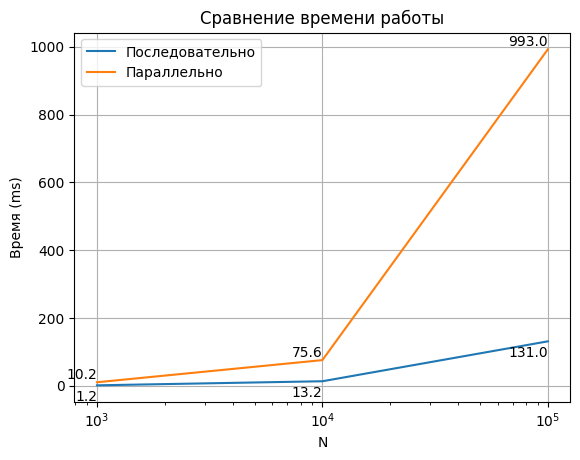

In [24]:
import matplotlib.pyplot as plt
ns = [1000, 10000, 100000]
s_times = [1.17, 13.2, 131.]
p_times = [10.2, 75.6, 993.]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
for x, y in zip(ns, s_times):
    plt.text(x, y-55, f'{y:.1f}', ha='right', va='bottom')

for x, y in zip(ns, p_times):
    plt.text(x, y, f'{y:.1f}', ha='right', va='bottom')
plt.title("Сравнение времени работы")
plt.xlabel("N")
plt.ylabel("Время (ms)")
plt.xscale('log')
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
plt.show()